In [1209]:
import pathlib
import zipfile
import os
import tensorflow as tf
from PIL import Image as Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import random
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [1210]:
#Use extract function in Préparation de données to get correct dataset
#Need livrable2 zip in correct directory architecture
dataset_path = "../DatasetL2/Project_Dataset_Unzip/Dataset"

In [1211]:
image_h = 320
image_w = 320
batch_s = 10

In [1212]:
#def load_data(data_path, test_size=0.2):
#    train = []
#    test = []
#    for file in os.listdir(data_path):
#        random_number = random.random()
#        image = Image.open(data_path + "\\" + file)
#        pix = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
#        if random_number < test_size :
#            test.append(pix)
#        else:
#            train.append(pix)
#    return train, test

#x_train, x_test = load_data(dataset_path)
#print(len(x_train))
#noise_factor = 0.5
#x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=len(x_train))

#x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=len(x_test))

#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [1213]:
print(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2)

120.0


In [1214]:
#print(x_train.__class__)
#print(len(x_train))
#print(x_test.__class__)
#print(x_train_noisy.__class__)
#print(x_train_noisy.shape)
#print(x_test_noisy.__class__)
#print(x_test_noisy.shape)

In [1215]:
def add_noise(img):
    noise_factor = 0.2
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    img = img + noise
    np.clip(img, 0., 1.)
    return img

def noisy(img):
    img_resc = [pix*1./255 for pix in img]
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img_resc + gauss
    return noisy

def noisy_image(img):
    return img-50

test_dataset_path = "../DatasetL2/Project_Dataset_Unzip/"
normal_datagen = ImageDataGenerator(
        rescale=1./255,
        #preprocessing_function=noisy,
        data_format="channels_last",
        validation_split=0.20
        )
noisy_datagen = ImageDataGenerator(
        #rescale=1./255,
        preprocessing_function=noisy,
        data_format="channels_last",
        validation_split=0.20
        )
train_generator = normal_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

train_noisy_generator = noisy_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_generator = normal_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_noisy_generator = noisy_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [1216]:
train_noisy= train_noisy_generator.next()
test_noisy= test_noisy_generator.next()
train = train_generator.next()
test = test_generator.next()
x_train = train
x_train_noisy = train_noisy
x_test = test
x_test_noisy = test_noisy

<class 'numpy.ndarray'>


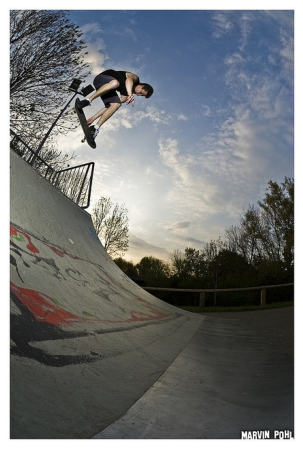

In [1217]:
from keras.preprocessing import image
def display_single_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[i].reshape(image_h, image_w,3))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#Print 1 image for testing
img = image.load_img('../DatasetL2/Project_Dataset_Unzip/Dataset/noisy_139.jpg')  # this is a PIL image
display_single_image(img)
#display_single_image(noisy(train_generator[0][0][0]))
print(train_generator[0][0][0].__class__)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


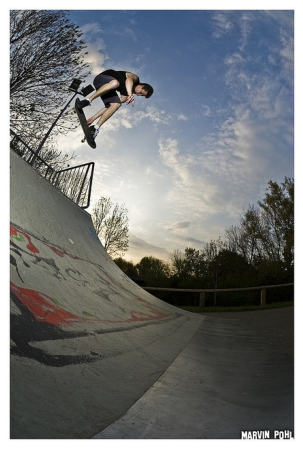

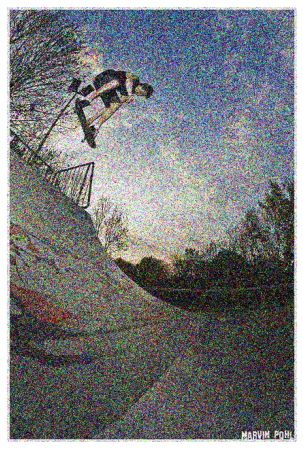

In [1218]:
#img = image.img_to_array(img)
img_decode = np.array(img)
print(img_decode.__class__)
display_single_image(img_decode)
display_single_image(noisy(img_decode))

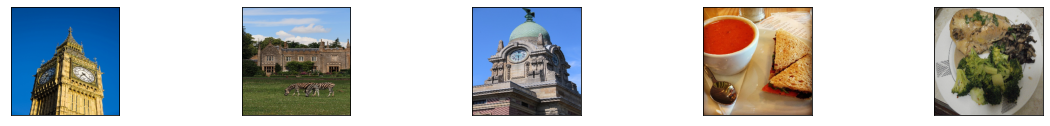

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

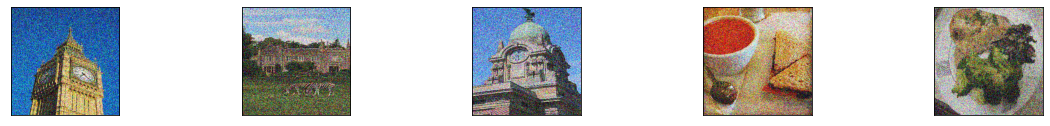

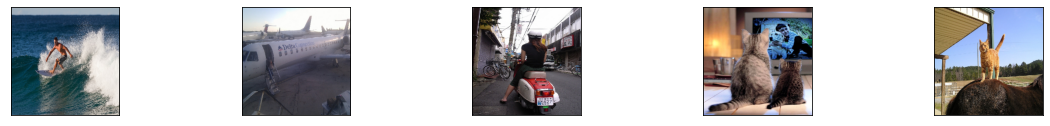

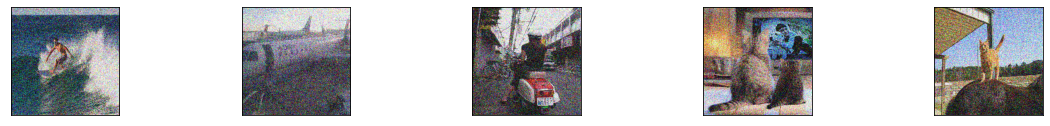

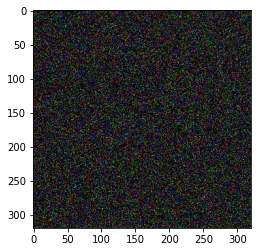

In [1219]:
display_image(x_train,5)
display_image(x_train_noisy,5)
display_image(x_test,5)
display_image(x_test_noisy,5)
plt.imshow(noisy(x_test_noisy[2]))

In [1220]:
input_img = keras.Input(shape=(image_h, image_w, 3))

encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

decoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

auto_encoder = keras.Model(input_img, decoded)
auto_encoder.compile(optimizer = 'adam',
                  loss = 'mean_squared_error')
auto_encoder.summary()
auto_encoder.fit(x_train_noisy, x_train,
                epochs=150,
                batch_size=batch_s,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
                )

#auto_encoder.fit_generator(train_generator,
#                           len(x_test_noisy)/batch_s,
#                           epochs=10,
#                           #validation_data=(x_test_noisy,x_test),
#                           )


Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 320, 320, 3)]     0         
_________________________________________________________________
conv2d_359 (Conv2D)          (None, 320, 320, 64)      1792      
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 160, 160, 32)      18464     
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 80, 80, 16)        4624      
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 40, 40, 16)        0  

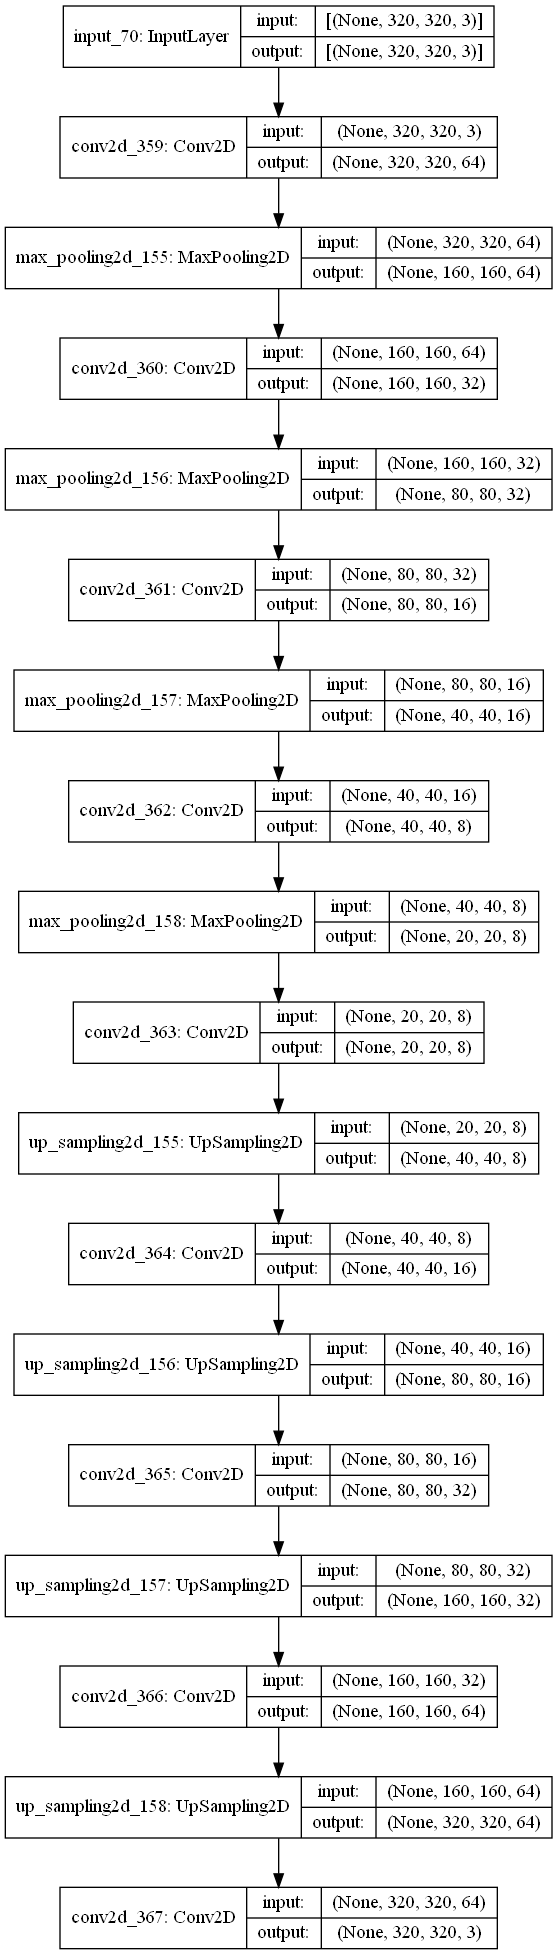

In [1221]:
tf.keras.utils.plot_model(auto_encoder, show_shapes=True)

In [1222]:
decoded_imgs = auto_encoder.predict(x_train_noisy, verbose=1)
print(decoded_imgs.shape)


1/1 [==============================] - 0s 431ms/step
(10, 320, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

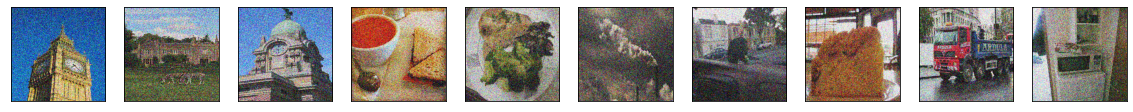

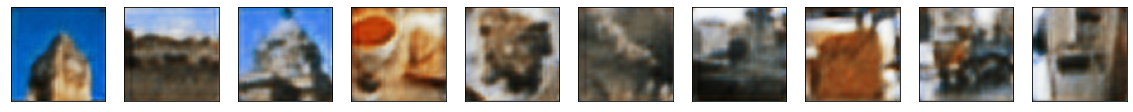

In [1223]:
display_image(x_train_noisy,10)
display_image(decoded_imgs,10)